# Log file: 15_59_10.ulg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def init_fonts(small=12, medium=16, big=24):
    SMALL_SIZE = small
    MEDIUM_SIZE = medium
    BIGGER_SIZE = big

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
init_fonts()

In [3]:
! ls

15_59_10_actuator_controls_0_0.csv
15_59_10_actuator_outputs_0.csv
15_59_10_actuator_outputs_1.csv
15_59_10_battery_status_0.csv
15_59_10_cpuload_0.csv
15_59_10_ekf2_innovations_0.csv
15_59_10_ekf2_timestamps_0.csv
15_59_10_estimator_status_0.csv
15_59_10_input_rc_0.csv
15_59_10_manual_control_setpoint_0.csv
15_59_10_manual_control_setpoint_1.csv
15_59_10_rate_ctrl_status_0.csv
15_59_10_sensor_combined_0.csv
15_59_10_sensor_preflight_0.csv
15_59_10_system_power_0.csv
15_59_10_telemetry_status_0.csv
15_59_10_trajectory_setpoint_0.csv
15_59_10_vehicle_air_data_0.csv
15_59_10_vehicle_attitude_0.csv
15_59_10_vehicle_attitude_setpoint_0.csv
15_59_10_vehicle_land_detected_0.csv
15_59_10_vehicle_local_position_0.csv
15_59_10_vehicle_local_position_setpoint_0.csv
15_59_10_vehicle_magnetometer_0.csv
15_59_10_vehicle_rates_setpoint_0.csv
15_59_10_vehicle_status_0.csv
15_59_10_vehicle_status_flags_0.csv
15_59_10_vehicle_visual_odometry_0.csv
postprocessing.ipynb


In [8]:
pose = pd.read_csv('15_59_10_vehicle_local_position_0.csv')
z = -pose.z
z[z<=0] = z[0]
t = ( pose.timestamp - pose.timestamp[0] ) / 10e5


sp = pd.read_csv('15_59_10_vehicle_local_position_setpoint_0.csv')
t_sp = ( sp.timestamp - pose.timestamp[0] ) / 10e5

## Coordinates

Text(0.5, 1.0, 'Drone coordinates')

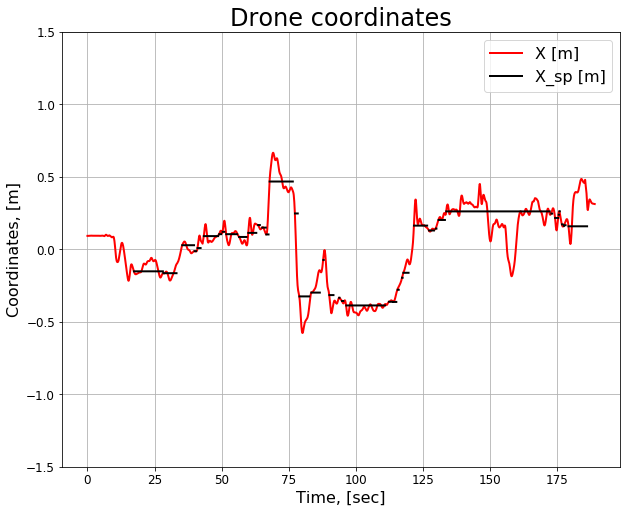

In [18]:
plt.figure(figsize=(10,8))
plt.plot(t, pose.x, color='r', linewidth=2, label='X [m]')
plt.plot(t_sp, sp.x, color='k', linewidth=2, label='X_sp [m]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Coordinates, [m]')
plt.ylim([-1.5, 1.5])
plt.title('Drone coordinates')

Text(0.5, 1.0, 'Drone coordinates')

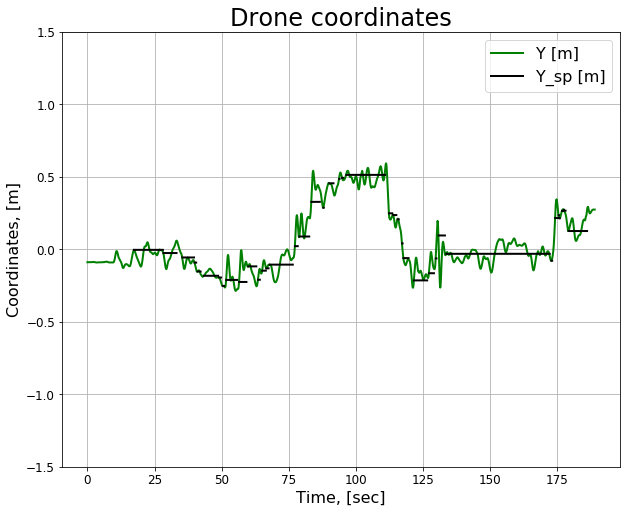

In [19]:
plt.figure(figsize=(10,8))
plt.plot(t, pose.y, color='g', linewidth=2, label='Y [m]')
plt.plot(t_sp, sp.y, color='k', linewidth=2, label='Y_sp [m]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Coordinates, [m]')
plt.ylim([-1.5, 1.5])
plt.title('Drone coordinates')

Text(0.5, 1.0, 'Drone coordinates')

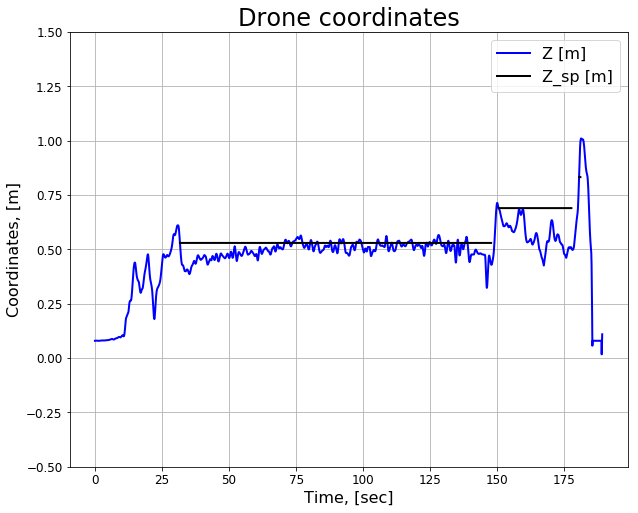

In [20]:
plt.figure(figsize=(10,8))
plt.plot(t, z, color='b', linewidth=2, label='Z [m]')
plt.plot(t_sp, -sp.z, color='k', linewidth=2, label='Z_sp [m]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Coordinates, [m]')
plt.ylim([-0.5, 1.5])
plt.title('Drone coordinates')

In [24]:
pose.columns

Index(['timestamp', 'ref_timestamp', 'ref_lat', 'ref_lon', 'x', 'y', 'z',
       'delta_xy[0]', 'delta_xy[1]', 'delta_z', 'vx', 'vy', 'vz', 'z_deriv',
       'delta_vxy[0]', 'delta_vxy[1]', 'delta_vz', 'ax', 'ay', 'az', 'yaw',
       'ref_alt', 'dist_bottom', 'dist_bottom_rate', 'eph', 'epv', 'evh',
       'evv', 'vxy_max', 'vz_max', 'hagl_min', 'hagl_max', 'xy_valid',
       'z_valid', 'v_xy_valid', 'v_z_valid', 'xy_reset_counter',
       'z_reset_counter', 'vxy_reset_counter', 'vz_reset_counter', 'xy_global',
       'z_global', 'dist_bottom_valid'],
      dtype='object')

## Angles

(-0.2, 0.3)

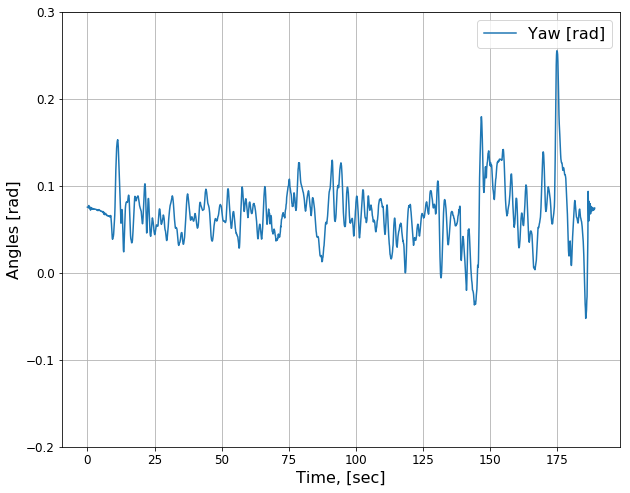

In [98]:
plt.figure(figsize=(10,8))
plt.plot(t, pose.yaw, label='Yaw [rad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Angles [rad]')
plt.ylim([-0.2, 0.3])


In [63]:
angles = pd.read_csv('15_59_10_vehicle_attitude_0.csv')
t_ang = ( angles.timestamp - pose.timestamp[0] ) / 10e5
Q0 = angles['q[0]']
Q1 = angles['q[1]']
Q2 = angles['q[2]']
Q3 = angles['q[3]']

angles_sp = pd.read_csv('15_59_10_vehicle_attitude_setpoint_0.csv')
t_ang_sp = ( angles_sp.timestamp - pose.timestamp[0] ) / 10e5
Q0_sp = angles_sp['q_d[0]']
Q1_sp = angles_sp['q_d[1]']
Q2_sp = angles_sp['q_d[2]']
Q3_sp = angles_sp['q_d[3]']

In [62]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.degrees(math.atan2(t3, t4))

    return Z, Y, X

In [79]:
roll = []; pitch = []; yaw = []
for q0, q1, q2, q3 in zip(Q0, Q1, Q2, Q3):
    r, p, y = quaternion_to_euler(q0, q1, q2, q3)
    roll.append(r); pitch.append(p); yaw.append(y)
    
roll_sp = []; pitch_sp = []; yaw_sp = []
for q0, q1, q2, q3 in zip(Q0_sp, Q1_sp, Q2_sp, Q3_sp):
    r, p, y = quaternion_to_euler(q0, q1, q2, q3)
    roll_sp.append(r); pitch_sp.append(p); yaw_sp.append(y)

In [80]:
# make angular values in range (0, 180) degrees
yaw = np.array(yaw)
yaw[yaw<0] += 360
yaw -= 180

yaw_sp = np.array(yaw_sp)
yaw_sp[yaw_sp<0] += 360
yaw_sp -= 180

pitch_sp = np.array(pitch_sp)
pitch_sp[abs(pitch_sp)>20] = pitch[0]

roll_sp = np.array(roll_sp)
roll_sp[abs(roll_sp)>20] = roll[0]

(-20, 20)

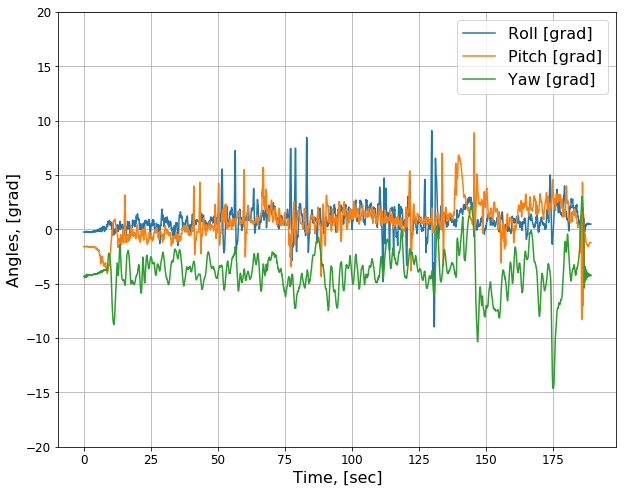

In [81]:
plt.figure(figsize=(10,8))
plt.plot(t_ang, roll, label='Roll [grad]')
plt.plot(t_ang, pitch, label='Pitch [grad]')
plt.plot(t_ang, yaw, label='Yaw [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Angles, [grad]')
plt.ylim([-20, 20])


## Angles with setpoints

(-15, 15)

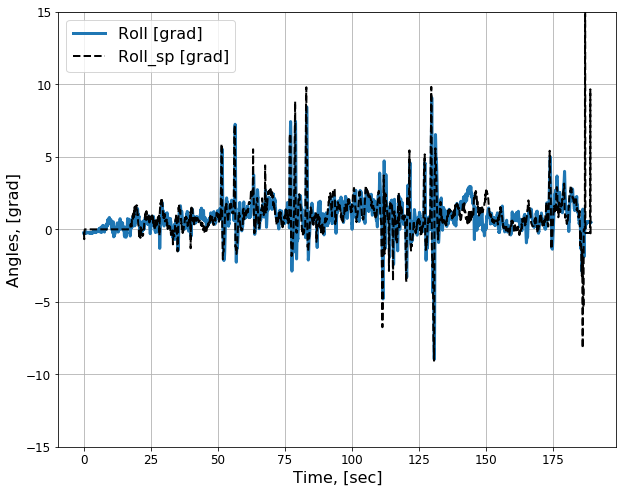

In [87]:
plt.figure(figsize=(10,8))
plt.plot(t_ang, roll, linewidth=3, label='Roll [grad]')
plt.plot(t_ang_sp, roll_sp, '--', color='k', linewidth=2, label='Roll_sp [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Angles, [grad]')
plt.ylim([-15, 15])

(-15, 15)

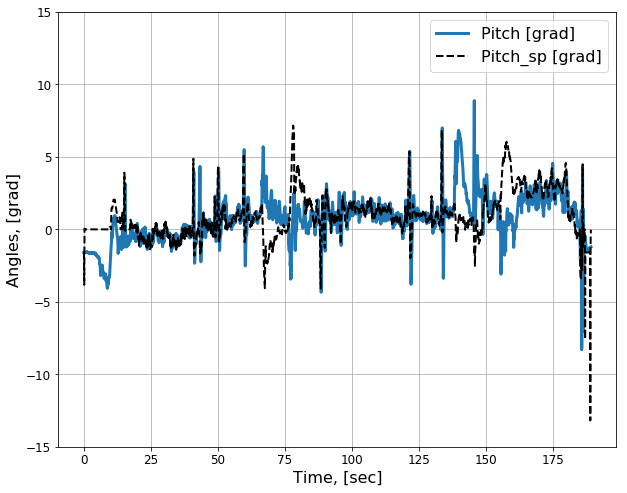

In [88]:
plt.figure(figsize=(10,8))
plt.plot(t_ang, pitch, linewidth=3, label='Pitch [grad]')
plt.plot(t_ang_sp, pitch_sp, '--', color='k', linewidth=2, label='Pitch_sp [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Angles, [grad]')
plt.ylim([-15, 15])

(-15, 10)

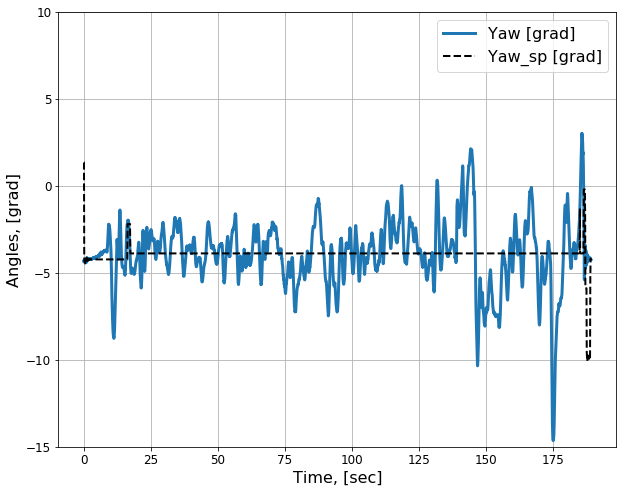

In [90]:
plt.figure(figsize=(10,8))
plt.plot(t_ang, yaw, linewidth=3, label='Yaw [grad]')
plt.plot(t_ang_sp, yaw_sp, '--', color='k', linewidth=2, label='Yaw_sp [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Angles, [grad]')
plt.ylim([-15, 10])

## Dependecies: X(pitch) and Y(roll)

(-1, 1)

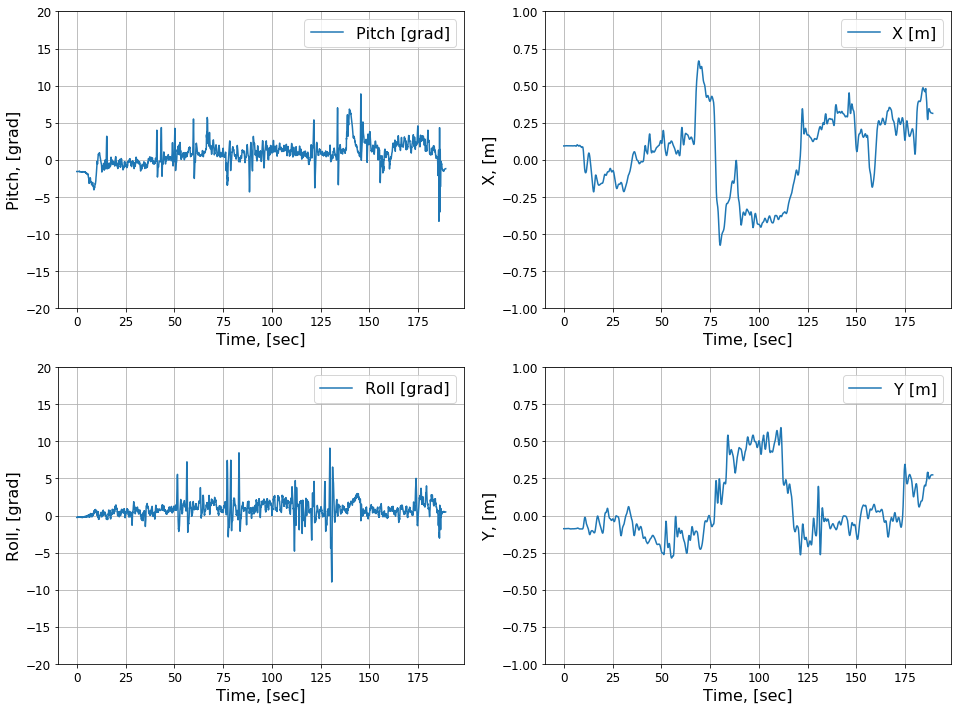

In [91]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.plot(t_ang, pitch, label='Pitch [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Pitch, [grad]')
plt.ylim([-20, 20])

plt.subplot(2,2,2)
plt.plot(t, pose.x, label='X [m]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('X, [m]')
plt.ylim([-1, 1])


plt.subplot(2,2,3)
plt.plot(t_ang, roll, label='Roll [grad]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Roll, [grad]')
plt.ylim([-20, 20])


plt.subplot(2,2,4)
plt.plot(t, pose.y, label='Y [m]')
plt.legend()
plt.grid()
plt.xlabel('Time, [sec]')
plt.ylabel('Y, [m]')
plt.ylim([-1, 1])
